In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import dataframe_image as dfi

# sklearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, RFECV

# Pandas display options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

#filter warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Prepare data
## First load sensor data file

In [58]:
sensor_df = pd.read_csv('data/HydraulicData.csv')

## Then load target condition data from profile.txt

In [59]:
# Load compoent value data files
profile_df = pd.read_csv('profile.txt', sep="\t", header=None)
profile_df.columns = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']
sensor_df = sensor_df.drop(columns=['Time'])

# Put sensor data and component value data together
hydraulic_df = pd.concat([sensor_df, profile_df], axis=1)

In [60]:
hydraulic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CE                     2205 non-null   float64
 1   CP                     2205 non-null   float64
 2   EPS1                   2205 non-null   float64
 3   FS1                    2205 non-null   float64
 4   FS2                    2205 non-null   float64
 5   PS1                    2205 non-null   float64
 6   PS2                    2205 non-null   float64
 7   PS3                    2205 non-null   float64
 8   PS4                    2205 non-null   float64
 9   PS5                    2205 non-null   float64
 10  PS6                    2205 non-null   float64
 11  SE                     2205 non-null   float64
 12  TS1                    2205 non-null   float64
 13  TS2                    2205 non-null   float64
 14  TS3                    2205 non-null   float64
 15  TS4 

# EDA

## Line charts for process degradation over time

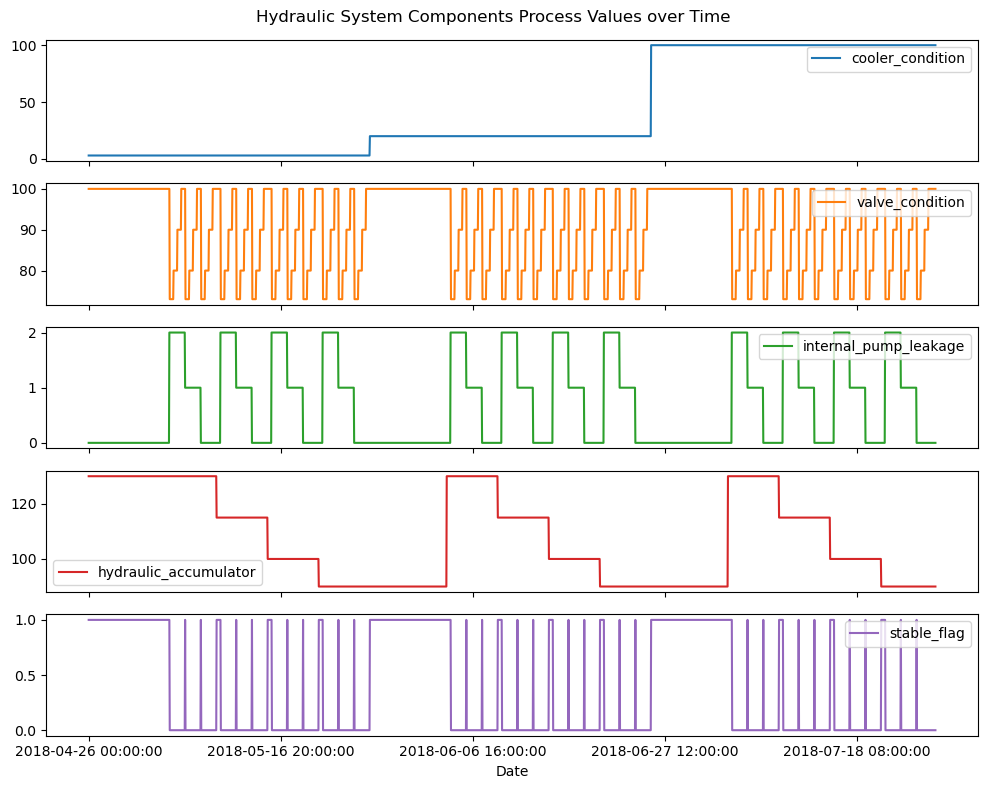

In [47]:
hydraulic_df.plot(x='Date',
              title = "Hydraulic System Components Process Values over Time",
              y=['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag'],
              figsize=(10,8),
              subplots=True)
plt.tight_layout()
plt.savefig('images/components_values.png', format='png')
plt.show()

## Sensor Data Histograms

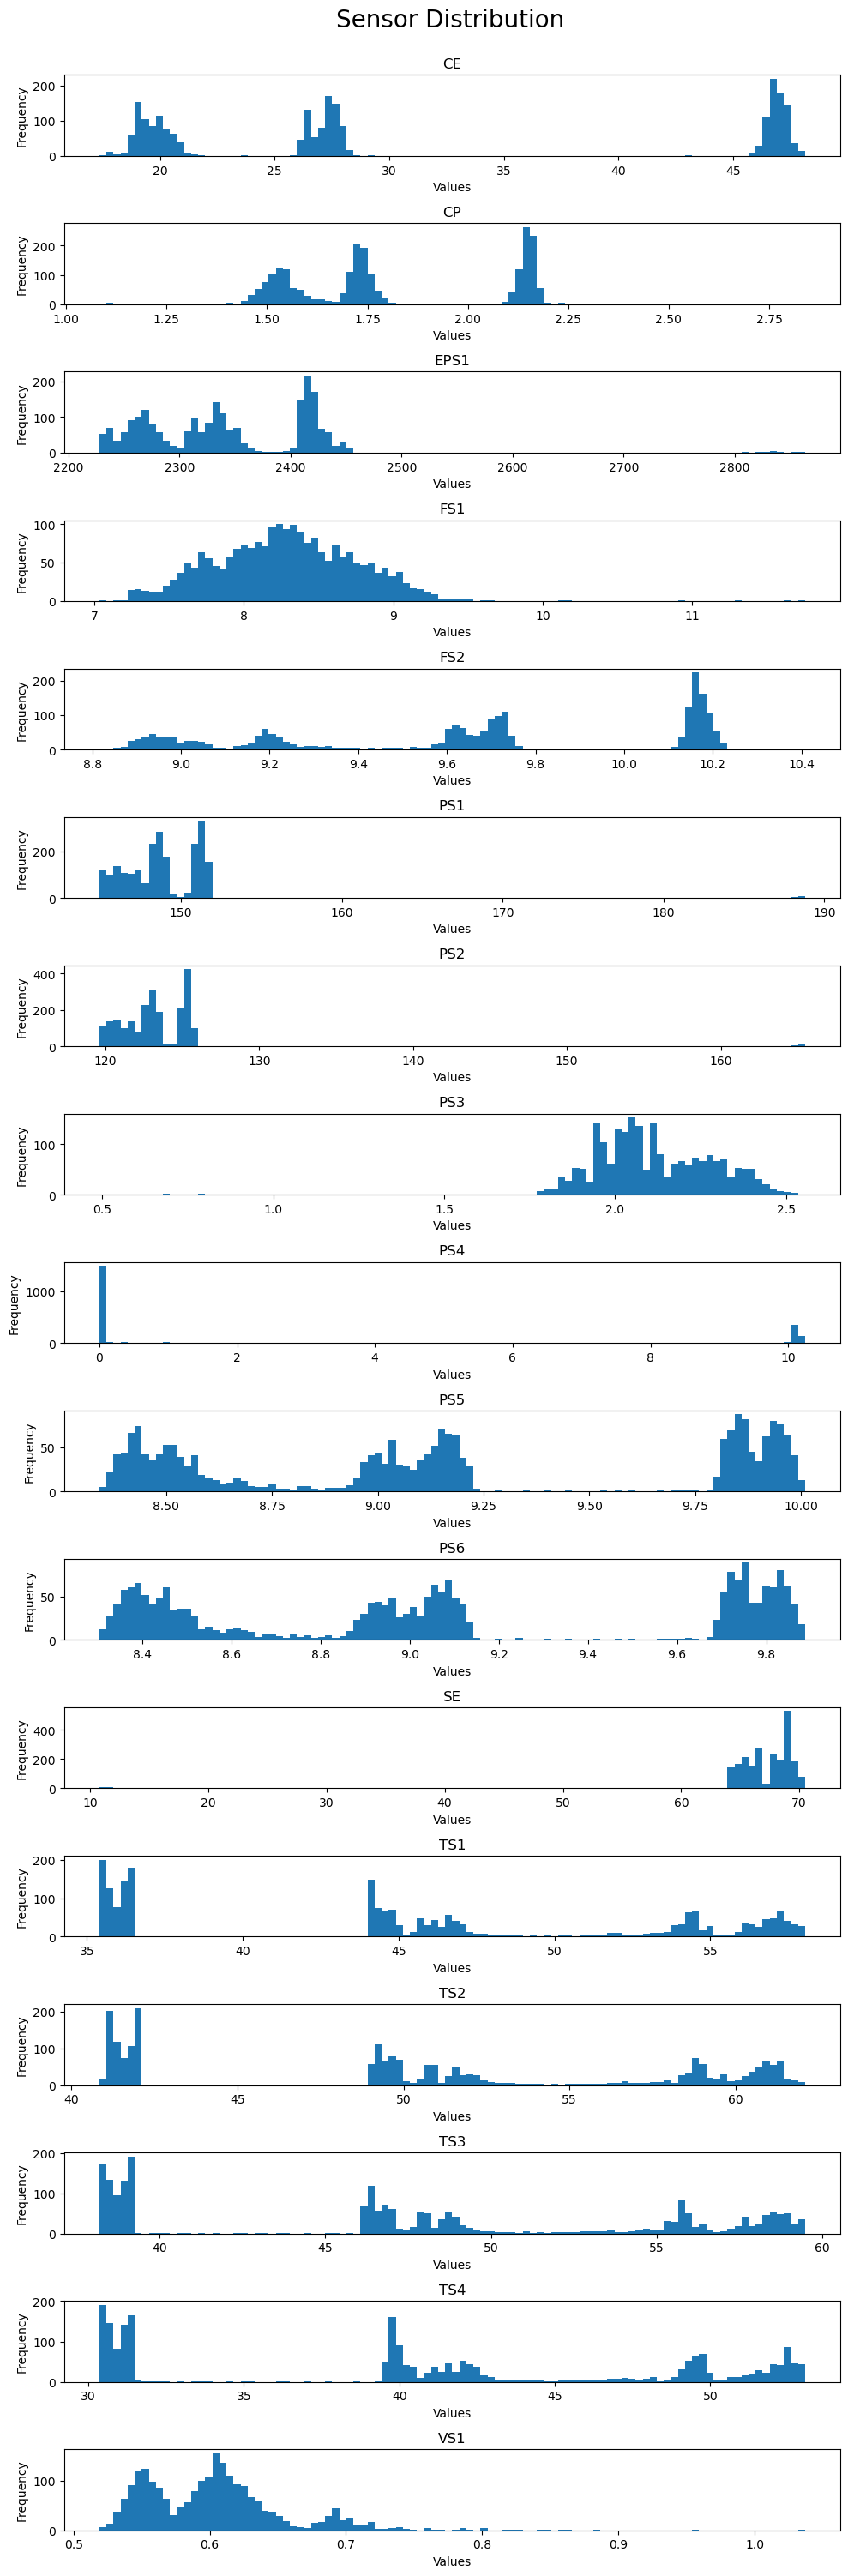

In [48]:
# Define the list of sensor columns
sensor_columns = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
                  'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

# Create subplots for each sensor
fig, axes = plt.subplots(nrows=len(sensor_columns), figsize=(10, 30))

# Set the title for the whole figure
fig.suptitle('Sensor Distribution', fontsize=20, x=.53, y=1)

# Iterate over each sensor column and plot histogram
for i, column in enumerate(sensor_columns):
    ax = axes[i]
    ax.hist(hydraulic_df[column], bins=100)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Sensor Data Boxplots

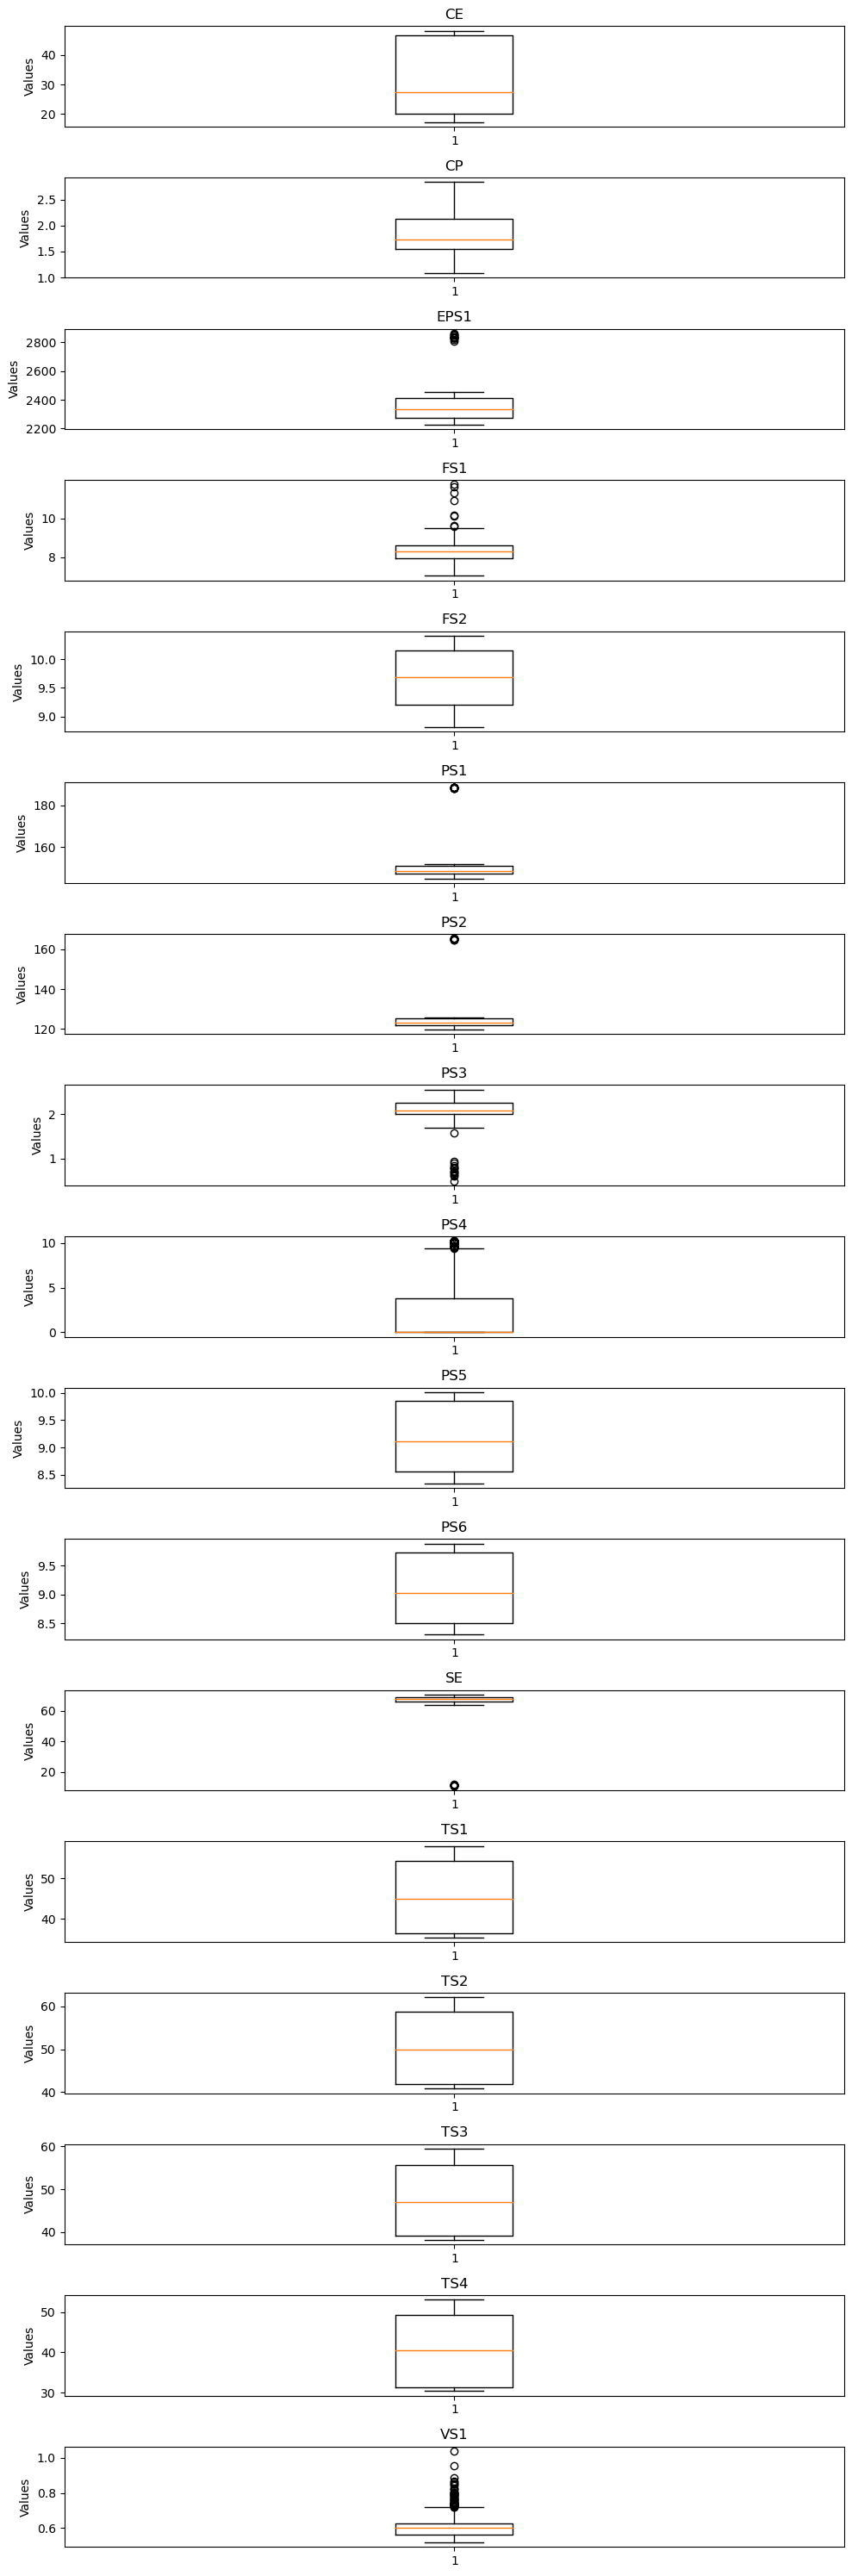

In [49]:
# Define the list of sensor columns
sensor_columns = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
                  'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

# Create subplots for each sensor
fig, axes = plt.subplots(nrows=len(sensor_columns), figsize=(10, 30))

# Iterate over each sensor column and plot box plot
for i, column in enumerate(sensor_columns):
    ax = axes[i]
    ax.boxplot(hydraulic_df[column])
    ax.set_title(column)
    ax.set_ylabel('Values')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Pairplot of Sensor Data

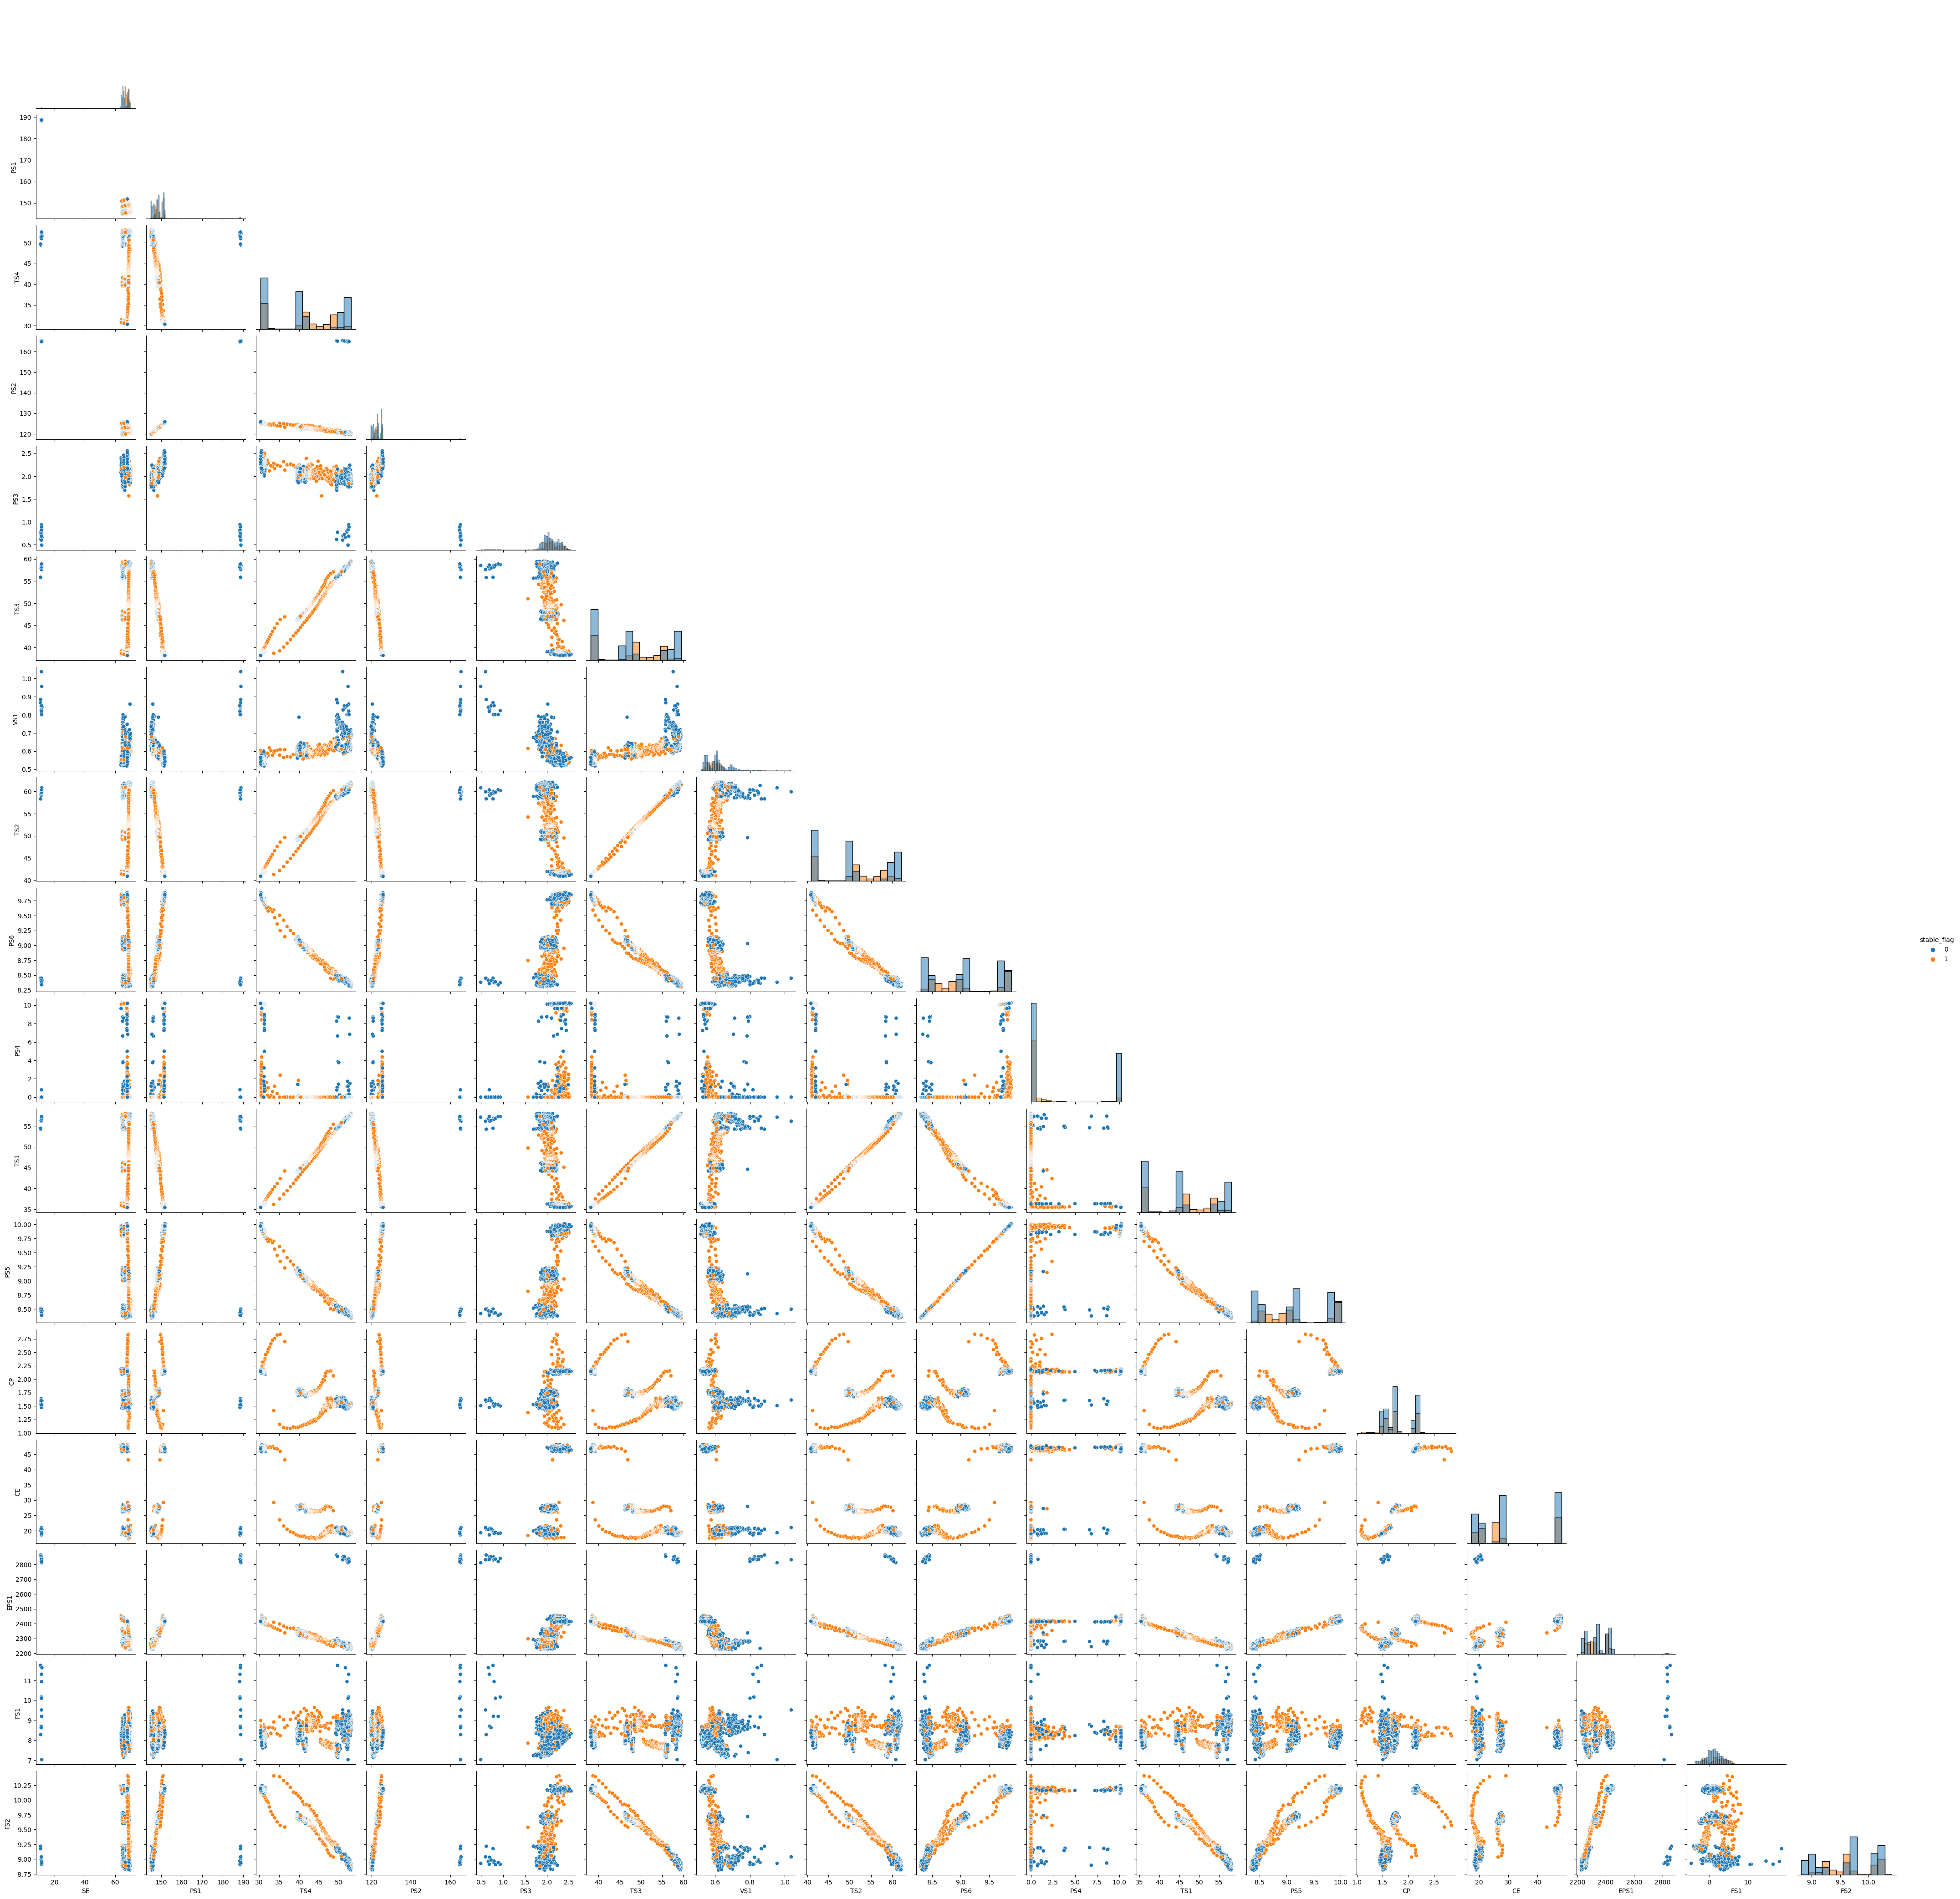

In [50]:
# Subset the columns for the pairplot
columns = ['SE', 'PS1', 'TS4', 'PS2', 'PS3', 'TS3', 'VS1', 'TS2', 'PS6', 
           'PS4', 'TS1', 'PS5', 'CP', 'CE', 'EPS1', 'FS1', 'FS2', 'stable_flag']

# Create the pairplot
sns.pairplot(hydraulic_df[columns], diag_kind='hist', hue = "stable_flag", corner=True)

# Show the plot
plt.show()

## Component Value Distribution

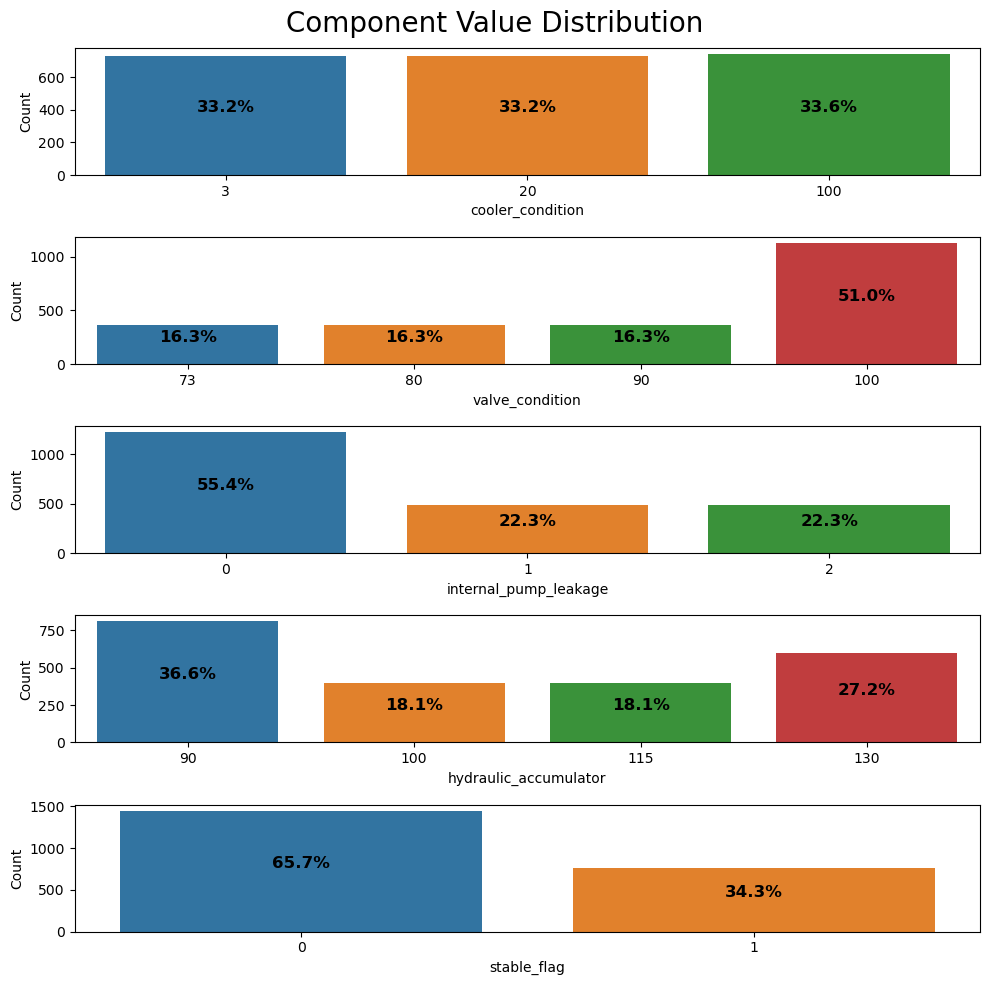

In [51]:
# Subset the columns
columns = ['cooler_condition','valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Create subplots
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 10))

# Set the title for the whole figure
fig.suptitle('Component Value Distribution', fontsize=20)

# Iterate over columns and plot count plots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.countplot(x=column, data=hydraulic_df, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

    # Calculate total count of records for the current column
    total = len(hydraulic_df[column])

    # Iterate over all bars and add percentage text inside each bar
    for p in ax.patches:
        height = p.get_height()
        # If height is 0, we want to avoid division by zero error
        if height == 0:
            continue
        percentage = f'{100 * height/total:.1f}%'
        ax.text(p.get_x()+p.get_width()/2., height/2, percentage, ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('images/Component_value_distributions.png', format='png')

# Show the plot
plt.show()

## Correlation heatmap

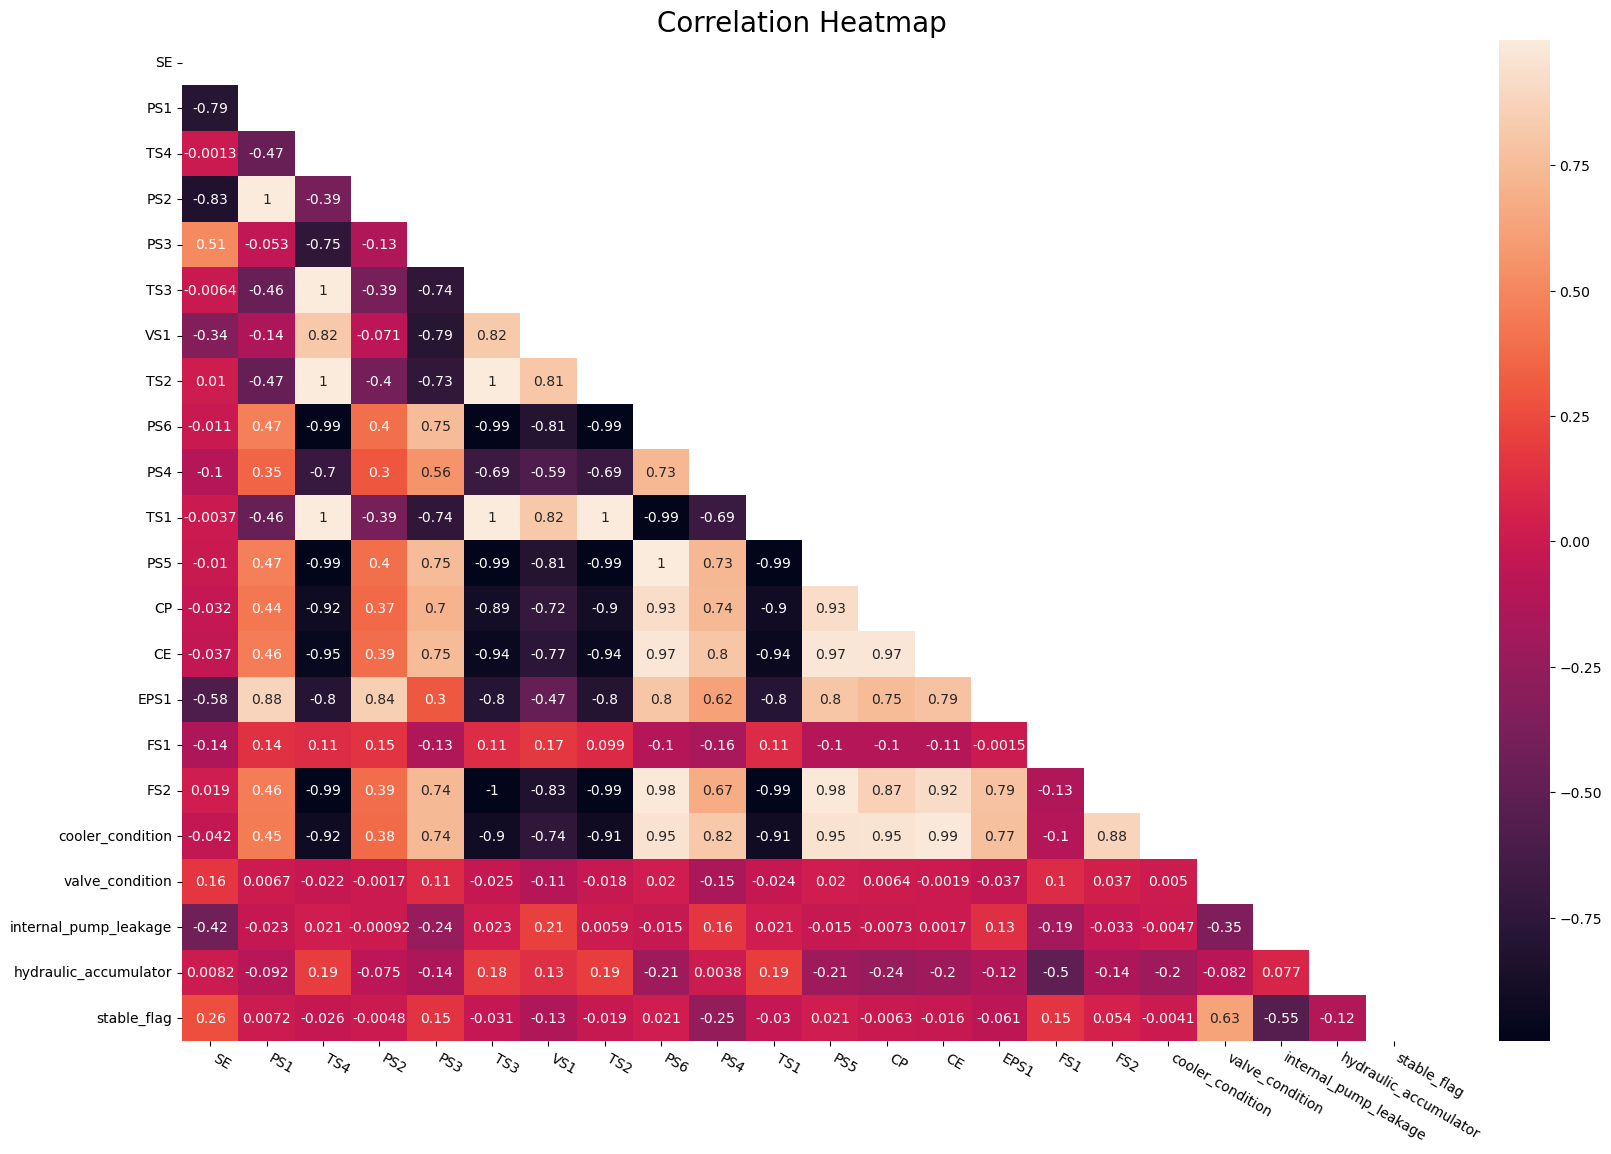

In [52]:
# Select the columns for correlation heatmap
columns = ['SE', 'PS1', 'TS4', 'PS2', 'PS3', 'TS3', 'VS1', 'TS2', 'PS6', 'PS4', 'TS1',
           'PS5', 'CP', 'CE', 'EPS1', 'FS1', 'FS2', 'cooler_condition', 'valve_condition',
           'internal_pump_leakage', 'hydraulic_accumulator', 'stable_flag']

# Create a new figure with a size of 20x13
fig, ax = plt.subplots(figsize=(20, 13))

# Extract the selected columns and compute the correlation matrix
correlation_matrix = hydraulic_df[columns].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot a heatmap of the correlation matrix with the mask applied
sns.heatmap(correlation_matrix, annot=True, ax=ax, mask=mask)

# Set the title and rotate x-axis labels
ax.set_title('Correlation Heatmap', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30, ha='left')

plt.savefig('images/correlation_heatmap.png', format='png')
# Show the plot
plt.show()

## Feature Importance - RandomForestClassifier

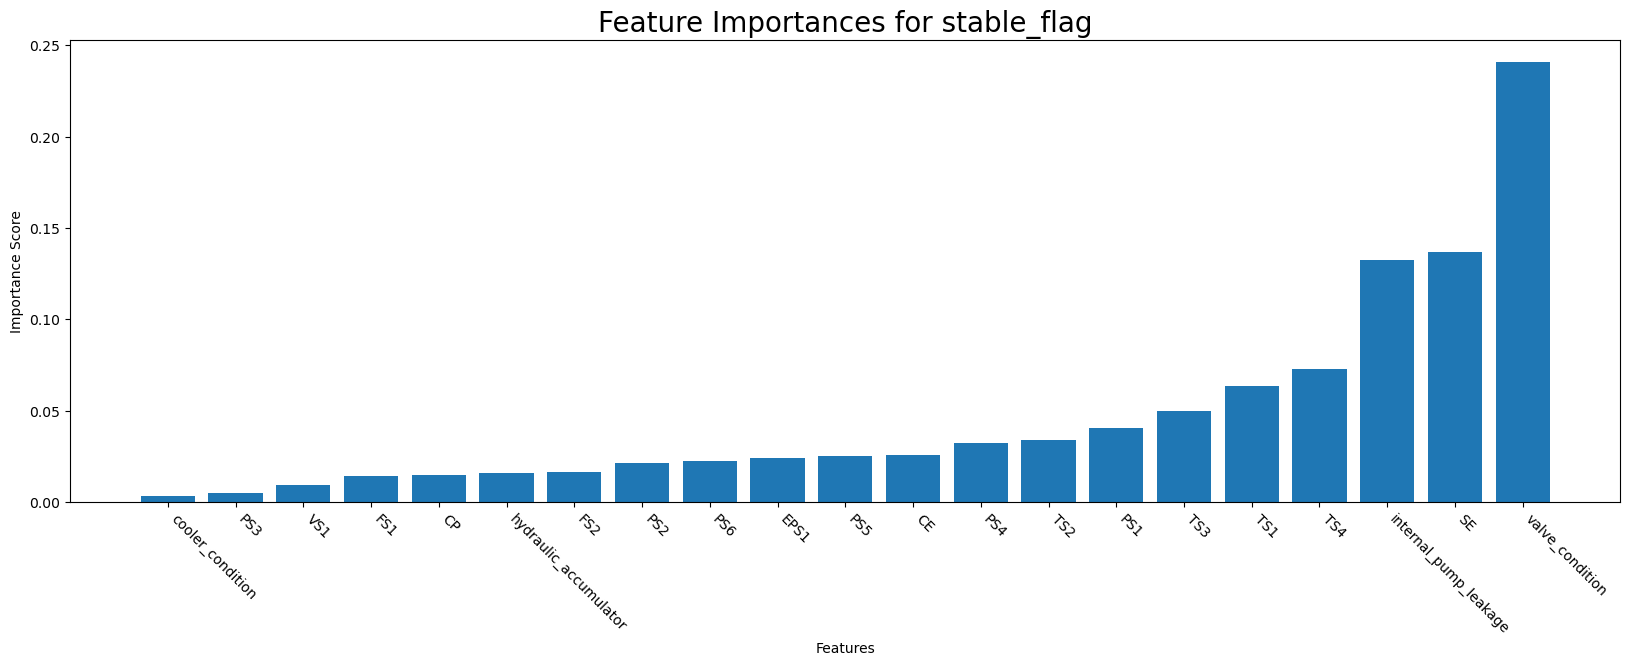

In [61]:
X = hydraulic_df.drop(columns=['Date','stable_flag'])
y = hydraulic_df['stable_flag']

# Create a RandomForestClassifier model
model = RandomForestClassifier()

# Train the model
model.fit(X,y)

# Get feature importances
importances = model.feature_importances_

# Sort before plot
df = pd.DataFrame(
   dict(
      cols=X.columns,
      values=importances
   )
)

df_sorted = df.sort_values('values')

# Plot feature importances
fig, ax = plt.subplots(figsize=(20,6))
#     ax.bar(X.columns, importances)
ax.bar('cols', 'values', data=df_sorted)
ax.set_xlabel('Features')
ax.set_ylabel('Importance Score')
ax.set_title(f"Feature Importances for stable_flag", fontsize= 20)
plt.xticks(rotation=-45, ha='left')

# Save the figure as a png file
# 'tight' parameter for bbox_inches ensures that the whole area of the figure is saved
plt.savefig('images/stable_flag_importances.png', bbox_inches='tight')

plt.show()


# ML - Using Random Forest Classification
## Train Test Split 

** Split your data into a training set and a testing set.**

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Feature scaling & Categorical data encoding

In [63]:
# Define the columns to be one-hot encoded and the columns for the quantile transformer
quant_features = ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5','PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']
categorical_features = ['cooler_condition', 'valve_condition', 'internal_pump_leakage', 'hydraulic_accumulator']

# Create instances of QuantileTransformer because of outlier in sensor data 
scaler = QuantileTransformer(output_distribution='normal', random_state=0)

# Feature scaling for quantile columns
X_train[quant_features] = scaler.fit_transform(X_train[quant_features])
X_test[quant_features] = scaler.transform(X_test[quant_features])

# Categorical data encoding using get_dummies (OneHotEncoder)
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

## Training the Random Forest Classification model on the Training set

In [64]:
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Model Evaluation
Now get predictions from the model and create a confusion matrix and a classification report.

In [66]:
predictions = classifier.predict(X_test)

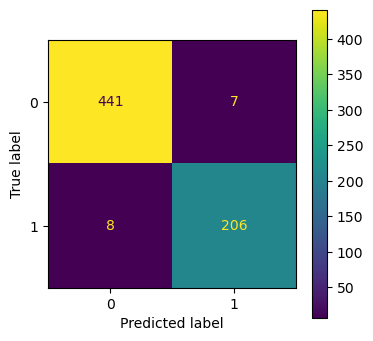

In [67]:
cnf_matrix = confusion_matrix(y_test,predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classifier.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.savefig('images/confusion matrix - initial training.png', bbox_inches='tight')
plt.show()

In [68]:
target_names = ['0: stable condition', '1: unstable condition']

cls_report = classification_report(y_test,predictions, output_dict=True, target_names=target_names)
cls_report_df = pd.DataFrame(cls_report).transpose().drop(index=['accuracy', 'macro avg'])
dfi.export(cls_report_df, 'images/classification report - initial training.png')
cls_report_df

,precision,recall,f1-score,support
0: stable condition,0.982183,0.984375,0.983278,448.0
1: unstable condition,0.967136,0.962617,0.964871,214.0
weighted avg,0.977319,0.977341,0.977327,662.0


## Hyperparameter Tuning for stable_flag

In [81]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Create the base model to tune
rf = RandomForestClassifier(random_state=0)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, 
                                   scoring='precision_weighted', 
                                   verbose=1, n_iter=10, cv=5)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': None}


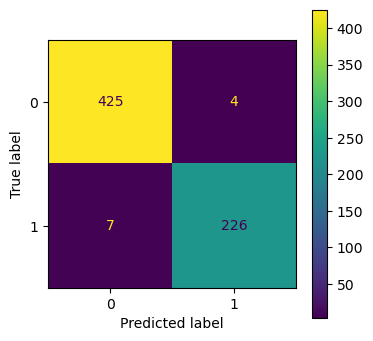

In [82]:
# Use the best model to make predictions on X_val
best_model = random_search.best_estimator_
best_predictions = best_model.predict(X_test)

# New Confusion matrix
cnf_matrix = confusion_matrix(y_test,best_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classifier.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.savefig('images/confusion matrix - after hyperparameter tuning.png', bbox_inches='tight')
plt.show()

In [83]:
# Compute precision, recall, and F1 score
best_cls_report = classification_report(y_test,best_predictions, output_dict=True, target_names=target_names)
best_cls_report_df = pd.DataFrame(best_cls_report).transpose().drop(index=['accuracy', 'macro avg'])
dfi.export(best_cls_report_df, 'images/classification report - after hyperparameter tuning.png')
best_cls_report_df

,precision,recall,f1-score,support
0: stable condition,0.983796,0.990676,0.987224,429.0
1: unstable condition,0.982609,0.969957,0.976242,233.0
weighted avg,0.983378,0.983384,0.983359,662.0


## Apply Feature selection and re-train Random Forest model

In [72]:
# Save feature names of dataset
feature_names = np.array(X.columns)

In [73]:
# Discard irrelevant features through Tree-based feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features=12)
X_new = model.transform(X)

X_new = pd.DataFrame(data = X_new, 
                  columns = feature_names[model.get_support()])

C:\Users\perry\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [74]:
X_new

,EPS1,PS1,PS2,PS4,PS6,SE,TS1,TS2,TS3,TS4,valve_condition,internal_pump_leakage
0,2411.6,151.47,125.50,0.000,9.818,68.039,35.570,40.961,38.320,30.363,100.0,0.0
1,2409.6,151.11,125.06,0.000,9.592,68.264,36.156,41.258,38.680,33.648,100.0,0.0
2,2397.8,150.81,125.13,0.000,9.505,68.595,37.488,42.129,39.234,35.113,100.0,0.0
3,2383.8,150.48,124.93,0.000,9.422,68.628,38.633,43.039,40.086,36.133,100.0,0.0
4,2372.0,150.41,124.72,0.000,9.315,68.868,39.461,44.031,40.934,36.992,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2200,2416.4,151.70,125.47,10.185,9.839,68.040,35.414,40.937,38.266,30.383,100.0,0.0
2201,2415.6,151.90,125.83,10.204,9.837,68.234,35.434,40.910,38.187,30.367,100.0,0.0
2202,2413.6,151.73,125.41,10.216,9.856,68.094,35.434,40.906,38.176,30.375,100.0,0.0
2203,2413.6,151.77,125.91,10.212,9.858,68.083,35.449,40.906,38.187,30.379,100.0,0.0


## Train Random forest model all over again using selected features

## Train Test Split 

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=101)

## Feature scaling & Categorical data encoding

In [76]:
# Define the columns to be one-hot encoded and the columns for the quantile transformer
quant_features = ['EPS1', 'PS1', 'PS4', 'PS2', 'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4']
categorical_features = ['valve_condition', 'internal_pump_leakage']

# Create instances of QuantileTransformer because of outlier in sensor data 
scaler = QuantileTransformer(output_distribution='normal', random_state=0)

# Feature scaling for quantile columns
X_train[quant_features] = scaler.fit_transform(X_train[quant_features])
X_test[quant_features] = scaler.transform(X_test[quant_features])

# Categorical data encoding using get_dummies (OneHotEncoder)
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

## Training the Random Forest Classification model on the Training set

In [77]:
classifier = RandomForestClassifier(random_state=101)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=101)

## Model Evaluation
Now get predictions from the model and create a confusion matrix and a classification report.

In [78]:
predictions = classifier.predict(X_test)

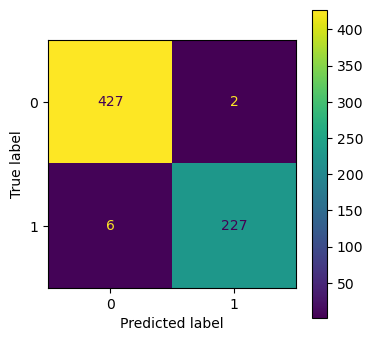

In [79]:
cnf_matrix = confusion_matrix(y_test,predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=classifier.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.savefig('images/confusion matrix - after feature selection.png', bbox_inches='tight')
plt.show()

In [80]:
cls_report = classification_report(y_test,predictions, output_dict=True, target_names=target_names)
cls_report_df = pd.DataFrame(cls_report).transpose().drop(index=['accuracy', 'macro avg'])
dfi.export(cls_report_df, 'images/classification report - after feature selection.png')
cls_report_df

,precision,recall,f1-score,support
0: stable condition,0.986143,0.995338,0.990719,429.0
1: unstable condition,0.991266,0.974249,0.982684,233.0
weighted avg,0.987946,0.987915,0.987891,662.0
